In [1]:
# !pip install imutils
import warnings
warnings.filterwarnings("ignore")

from keras.applications import VGG16
from keras.layers.core import Dense, Flatten, Dropout
from sklearn.model_selection import GridSearchCV, train_test_split
from keras.callbacks import BaseLogger, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import RMSprop, SGD
import numpy as np
import os
import cv2

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.models import Model

import imutils
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

Using TensorFlow backend.


## constant variables

In [2]:
DATA_DIR = "output/"
HEIGHT = 224
WIDTH = 224
CHANNEL = 3
BATCH_SIZE = 32
TEST_DIR = "datasets/yzm/"

class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9",
               "A", "B", "C", "D", "E", "F", "G", "H", "I", "J",
               "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", 
               "U", "V", "W", "X", "Y", "Z"]

## Model

In [3]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, CHANNEL))

In [4]:
for i, layer in enumerate(base_model.layers):
    print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	Conv2D
[INFO] 3	MaxPooling2D
[INFO] 4	Conv2D
[INFO] 5	Conv2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	Conv2D
[INFO] 9	Conv2D
[INFO] 10	MaxPooling2D
[INFO] 11	Conv2D
[INFO] 12	Conv2D
[INFO] 13	Conv2D
[INFO] 14	MaxPooling2D
[INFO] 15	Conv2D
[INFO] 16	Conv2D
[INFO] 17	Conv2D
[INFO] 18	MaxPooling2D


In [5]:
class FCHeadNet:
    @staticmethod
    def build(base_model, classes, D):
        head_model = base_model.output
        head_model = Flatten(name="Flatten")(head_model)
        head_model = Dense(D, activation="relu")(head_model)
        head_model = Dropout(0.5)(head_model)
        
        head_model = Dense(classes, activation="softmax")(head_model)
        return head_model

In [6]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

In [7]:
def load_image_paths(data_path):
    image_paths = []
    labels = []
    
    for cla in os.listdir(data_path):
        if cla == ".DS_Store": continue
        cla_path = os.path.join(data_path, cla)
        label = cla
        
        for img in os.listdir(cla_path):
            if img == ".DS_Store": continue
            image_path = os.path.join(cla_path, img)
            image_paths.append(image_path)
            labels.append(label)
    labels = np.array(labels)
    image_paths = np.array(image_paths)
    
    return image_paths, labels

In [8]:
image_paths, labels = load_image_paths(DATA_DIR)

In [9]:
image_paths, labels = shuffle(image_paths, labels, random_state=42)

In [10]:
(train_X_paths, test_X_paths, train_y, test_y) = train_test_split(image_paths, labels, test_size=0.25, random_state=42)

In [11]:
le = LabelBinarizer().fit(class_names)

In [12]:
train_y = le.transform(train_y)
test_y = le.transform(test_y)

In [13]:
class DataGener:
    def __init__(self, train_X_paths, test_X_paths, train_y, test_y):
        self.train_X_paths = train_X_paths
        self.test_X_paths = test_X_paths
        self.train_y = train_y
        self.test_y = test_y
        self.batch_size = BATCH_SIZE
        self.current_train = 0
        self.current_test = 0
    
    def preprocessing_image(self, image):
        h, w, c = image.shape
        d_w = 0
        d_h = 0 

        if w > h:
            image = imutils.resize(image, height=HEIGHT)
            d_w = int((image.shape[1] - WIDTH)/2)
        else:
            image = imutils.resize(image, width=WIDTH)
            d_h = int((image.shape[0] - HEIGHT)/2)

        image = image[d_h:image.shape[0]-d_h, d_w:image.shape[1]-d_w]
        image = cv2.resize(image, (HEIGHT, WIDTH), interpolation=cv2.INTER_AREA)

        return image
    
    def load_image(self, image_paths):
        images = []

        for img_path in image_paths:
            image = cv2.imread(img_path)
            image = self.preprocessing_image(image)
            image = image / 255
            images.append(image)

        images = np.array(images)
        return images
    
    def next_train(self):
        if self.current_train + self.batch_size > len(self.train_X_paths):
            self.current_train = 0
            self.train_X_paths, self.train_y = shuffle(self.train_X_paths, self.train_y, random_state=42)
        
        batch_img_paths = self.train_X_paths[self.current_train:self.current_train + self.batch_size]
        batch_imgs = self.load_image(batch_img_paths)
        batch_labels = self.train_y[self.current_train:self.current_train+self.batch_size]
        self.current_train += self.batch_size
        
        return batch_imgs, batch_labels
    
    def next_test(self):
        if self.current_test+ self.batch_size > len(self.test_X_paths):
            self.current_test = 0
            self.test_X_paths, self.test_y = shuffle(self.test_X_paths, self.test_y, random_state=42)
        
        batch_img_paths = self.test_X_paths[self.current_test:self.current_test + self.batch_size]
        batch_imgs = self.load_image(batch_img_paths)
        batch_labels = self.test_y[self.current_test:self.current_test+self.batch_size]
        self.current_test += self.batch_size
        
        return batch_imgs, batch_labels
    
    def get_batch(self, s="train"):
        while True:
            if s == "train":
                batch_X, batch_y = self.next_train()
            else:
                batch_X, batch_y = self.next_test()
                
            yield (batch_X, batch_y)

In [14]:
data_gener = DataGener(train_X_paths, test_X_paths, train_y, test_y)

In [15]:
test_X = data_gener.load_image(test_X_paths)

In [16]:
head_model = FCHeadNet.build(base_model, len(le.classes_), 256)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
for layer in base_model.layers:
    layer.trainable = False

In [18]:
model = Model(inputs=base_model.input, outputs=head_model)

In [19]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [20]:
opt = RMSprop(lr=0.001)

In [21]:
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [44]:
H = model.fit_generator(data_gener.get_batch(), 
                    validation_data=(test_X, test_y), 
                    validation_steps=len(test_X_paths) // BATCH_SIZE, 
                    epochs=25, steps_per_epoch=len(train_X_paths) // BATCH_SIZE,
                    verbose=1)

Epoch 1/25
198/198 [==============================] - 24s 122ms/step - loss: 2.7165 - accuracy: 0.2566 - val_loss: 1.1265 - val_accuracy: 0.8231
Epoch 2/25
198/198 [==============================] - 24s 122ms/step - loss: 1.5166 - accuracy: 0.5112 - val_loss: 0.4047 - val_accuracy: 0.9546
Epoch 3/25
198/198 [==============================] - 24s 119ms/step - loss: 1.1402 - accuracy: 0.5996 - val_loss: 0.1860 - val_accuracy: 0.9697
Epoch 4/25
198/198 [==============================] - 24s 121ms/step - loss: 0.9930 - accuracy: 0.6504 - val_loss: 0.1981 - val_accuracy: 0.9593
Epoch 5/25
198/198 [==============================] - 24s 120ms/step - loss: 0.9002 - accuracy: 0.6741 - val_loss: 0.1077 - val_accuracy: 0.9650
Epoch 6/25
198/198 [==============================] - 24s 119ms/step - loss: 0.8659 - accuracy: 0.6749 - val_loss: 0.0987 - val_accuracy: 0.9702
Epoch 7/25
198/198 [==============================] - 24s 121ms/step - loss: 0.8236 - accuracy: 0.6970 - val_loss: 0.0859 - val_ac

In [22]:
le.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], dtype='<U1')

In [24]:
# print("Plot classification report")
# predictions = model.predict(test_X)

# print(classification_report(predictions.argmax(axis=1), test_y.argmax(axis=1), target_names=le.classes_))

In [25]:
for layer in model.layers[15:]:
    layer.trainable = True

In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [27]:
weight_dir = "./weights"

if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)

In [28]:
best_weight_path = os.path.join(weight_dir, "best_weight.hdf5")

In [29]:
checkpoint = ModelCheckpoint(best_weight_path, mode="min", monitor="val_loss", verbose=1, save_best_only=True)

In [31]:
opt = SGD(lr=0.001)

In [32]:
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [54]:
H = model.fit_generator(data_gener.get_batch(), 
                    validation_data=(test_X, test_y), 
                    validation_steps=len(test_X_paths) // BATCH_SIZE, 
                    epochs=100, steps_per_epoch=len(train_X_paths) // BATCH_SIZE,
                    verbose=1, callbacks=[checkpoint])

Epoch 1/100
198/198 [==============================] - 26s 133ms/step - loss: 4.1043 - accuracy: 0.0350 - val_loss: 3.5850 - val_accuracy: 0.0449

Epoch 00001: val_loss improved from inf to 3.58496, saving model to ./weights/best_weight.hdf5
Epoch 2/100
198/198 [==============================] - 25s 129ms/step - loss: 3.6089 - accuracy: 0.0246 - val_loss: 3.5935 - val_accuracy: 0.0166

Epoch 00002: val_loss did not improve from 3.58496
Epoch 3/100
198/198 [==============================] - 26s 131ms/step - loss: 3.5806 - accuracy: 0.0426 - val_loss: 3.5018 - val_accuracy: 0.0728

Epoch 00003: val_loss improved from 3.58496 to 3.50179, saving model to ./weights/best_weight.hdf5
Epoch 4/100
198/198 [==============================] - 25s 129ms/step - loss: 3.5099 - accuracy: 0.0691 - val_loss: 3.3855 - val_accuracy: 0.0790

Epoch 00004: val_loss improved from 3.50179 to 3.38554, saving model to ./weights/best_weight.hdf5
Epoch 5/100
198/198 [==============================] - 26s 130ms/ste

198/198 [==============================] - 26s 130ms/step - loss: 0.0545 - accuracy: 0.9717 - val_loss: 0.0570 - val_accuracy: 0.9768

Epoch 00077: val_loss did not improve from 0.05178
Epoch 78/100
198/198 [==============================] - 26s 129ms/step - loss: 0.0532 - accuracy: 0.9738 - val_loss: 0.0567 - val_accuracy: 0.9773

Epoch 00078: val_loss did not improve from 0.05178
Epoch 79/100
198/198 [==============================] - 26s 130ms/step - loss: 0.0574 - accuracy: 0.9741 - val_loss: 0.0534 - val_accuracy: 0.9759

Epoch 00079: val_loss did not improve from 0.05178
Epoch 80/100
198/198 [==============================] - 26s 130ms/step - loss: 0.0572 - accuracy: 0.9736 - val_loss: 0.0552 - val_accuracy: 0.9735

Epoch 00080: val_loss did not improve from 0.05178
Epoch 81/100
198/198 [==============================] - 26s 129ms/step - loss: 0.0530 - accuracy: 0.9741 - val_loss: 0.0552 - val_accuracy: 0.9754

Epoch 00081: val_loss did not improve from 0.05178
Epoch 82/100
198/1

In [55]:
predictions = model.predict(test_X)

print(classification_report(predictions.argmax(axis=1), test_y.argmax(axis=1), target_names=class_names))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        79
           1       1.00      1.00      1.00       101
           2       1.00      1.00      1.00        88
           3       1.00      1.00      1.00        95
           4       1.00      1.00      1.00        93
           5       1.00      1.00      1.00        86
           6       1.00      1.00      1.00        70
           7       1.00      1.00      1.00        99
           8       1.00      0.99      0.99        87
           9       0.99      1.00      0.99        84
           A       1.00      1.00      1.00        45
           B       1.00      1.00      1.00        51
           C       1.00      1.00      1.00        48
           D       1.00      1.00      1.00        48
           E       1.00      1.00      1.00        57
           F       1.00      1.00      1.00        59
           G       1.00      1.00      1.00        47
           H       1.00    

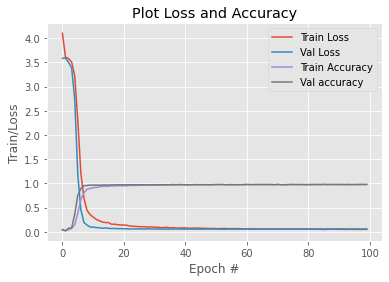

In [58]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="Train Loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="Val Loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="Val accuracy")
plt.title("Plot Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Train/Loss")
plt.legend()
plt.show()

## Prediction

In [33]:
from numpy.random import randint

In [34]:
idx = randint(0, len(image_paths))

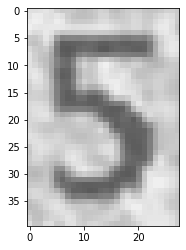

In [35]:
plt.imshow(cv2.imread(image_paths[idx]))

In [36]:
image = data_gener.load_image([image_paths[idx]])

In [37]:
class_names[model.predict(image).argmax(axis=1)[0]]

'S'

In [38]:
model.load_weights("best_weight.hdf5")

In [39]:
image_paths = os.listdir(TEST_DIR)

In [40]:
from numpy.random import randint

In [74]:
def image_prediction():
    idx = randint(0, len(image_paths))
    img_path = os.path.join(TEST_DIR, image_paths[idx])
    image = cv2.imread(img_path)
    plt.imshow(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:4]
    
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)

        if w > 40:
            roi = gray[y-5:y+5+h, x-5:x + int(w/2)]
            roi_2 = gray[y-5:y+5+h, x + int(w/2):x+5+int(w/2)]
            roi = cv2.merge([roi]*3)
            roi = data_gener.preprocessing_image(roi)
            roi_2 = cv2.merge([roi_2]*3)
            roi_2 = data_gener.preprocessing_image(roi_2)
#             rois = np.array([roi, roi_2])
        else:
            cv2.rectangle(image, (x-2, y-2), (x+w+2, y+h+2), (0, 255, 0), 1)
            roi = gray[y-5:y+5+h, x-5:x+5+w]
            roi = cv2.merge([roi]*3)
            roi = data_gener.preprocessing_image(roi)
#             rois = np.array([roi])
            prediction = model.predict(roi.reshape(1, 224, 224, 3))
            text = le.classes_[prediction.argmax(axis=1)[0]]
            cv2.putText(image, text, (x, y+h-2), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 1)

#         for roi in rois:
#             prediction = model.predict(roi.reshape(1, 224, 224, 3))
#             print(le.classes_[prediction.argmax(axis=1)[0]])
    plt.imshow(image)

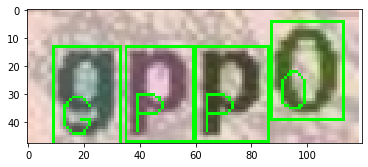

In [95]:
image_prediction()